In [1]:
! pip install python-chess

Defaulting to user installation because normal site-packages is not writeable


Please see https://github.com/pypa/pip/issues/5599 for advice on fixing the underlying issue.
To avoid this problem you can invoke Python with '-m pip' instead of running pip directly.


In [2]:
import numpy as np
import chess
import chess.pgn
import tensorflow as tf
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt

from keras.layers import Input, Dense, Flatten, Concatenate, Conv2D, Dropout
from keras.losses import mean_squared_error
from keras.models import Model, clone_model, load_model
from tensorflow.keras.optimizers import SGD, Adam, RMSprop
import numpy as np

In [3]:
class Agent(object):

    def __init__(self, lr=0.003, network='big'):
        self.optimizer = RMSprop(lr=lr)
        self.model = Model()
        self.proportional_error = False
        if network == 'simple':
            self.init_simple_network()
        elif network == 'super_simple':
            self.init_super_simple_network()
        elif network == 'alt':
            self.init_altnet()
        elif network == 'big':
            self.init_bignet()
        else:
            self.init_network()

    def fix_model(self):
        """
        The fixed model is the model used for bootstrapping
        Returns:
        """

        self.fixed_model = clone_model(self.model)
        self.fixed_model.compile(optimizer=self.optimizer, loss='mse', metrics=['mae'])
        self.fixed_model.set_weights(self.model.get_weights())

    def init_network(self):
        layer_state = Input(shape=(8, 8, 8), name='state')

        openfile = Conv2D(3, (8, 1), padding='valid', activation='relu', name='fileconv')(layer_state)  # 3,8,1
        openrank = Conv2D(3, (1, 8), padding='valid', activation='relu', name='rankconv')(layer_state)  # 3,1,8
        quarters = Conv2D(3, (4, 4), padding='valid', activation='relu', name='quarterconv', strides=(4, 4))(
            layer_state)  # 3,2,2
        large = Conv2D(8, (6, 6), padding='valid', activation='relu', name='largeconv')(layer_state)  # 8,2,2

        board1 = Conv2D(16, (3, 3), padding='valid', activation='relu', name='board1')(layer_state)  # 16,6,6
        board2 = Conv2D(20, (3, 3), padding='valid', activation='relu', name='board2')(board1)  # 20,4,4
        board3 = Conv2D(24, (3, 3), padding='valid', activation='relu', name='board3')(board2)  # 24,2,2

        flat_file = Flatten()(openfile)
        flat_rank = Flatten()(openrank)
        flat_quarters = Flatten()(quarters)
        flat_large = Flatten()(large)

        flat_board = Flatten()(board1)
        flat_board3 = Flatten()(board3)

        dense1 = Concatenate(name='dense_bass')(
            [flat_file, flat_rank, flat_quarters, flat_large, flat_board, flat_board3])
        dropout1 = Dropout(rate=0.1)(dense1)
        dense2 = Dense(128, activation='sigmoid')(dropout1)
        dense3 = Dense(64, activation='sigmoid')(dense2)
        dropout3 = Dropout(rate=0.1)(dense3, training=True)
        dense4 = Dense(32, activation='sigmoid')(dropout3)
        dropout4 = Dropout(rate=0.1)(dense4, training=True)

        value_head = Dense(1)(dropout4)
        self.model = Model(inputs=layer_state,
                           outputs=[value_head])
        self.model.compile(optimizer=self.optimizer,
                           loss=[mean_squared_error]
                           )

    def init_simple_network(self):

        layer_state = Input(shape=(8, 8, 8), name='state')
        conv1 = Conv2D(8, (3, 3), activation='sigmoid')(layer_state)
        conv2 = Conv2D(6, (3, 3), activation='sigmoid')(conv1)
        conv3 = Conv2D(4, (3, 3), activation='sigmoid')(conv2)
        flat4 = Flatten()(conv3)
        dense5 = Dense(24, activation='sigmoid')(flat4)
        dense6 = Dense(8, activation='sigmoid')(dense5)
        value_head = Dense(1)(dense6)

        self.model = Model(inputs=layer_state,
                           outputs=value_head)
        self.model.compile(optimizer=self.optimizer,
                           loss=mean_squared_error
                           )

    def init_super_simple_network(self):
        layer_state = Input(shape=(8, 8, 8), name='state')
        conv1 = Conv2D(8, (3, 3), activation='sigmoid')(layer_state)
        flat4 = Flatten()(conv1)
        dense5 = Dense(10, activation='sigmoid')(flat4)
        value_head = Dense(1)(dense5)

        self.model = Model(inputs=layer_state,
                           outputs=value_head)
        self.model.compile(optimizer=self.optimizer,
                           loss=mean_squared_error
                           )

    def init_altnet(self):
        layer_state = Input(shape=(8, 8, 8), name='state')
        conv1 = Conv2D(6, (1, 1), activation='sigmoid')(layer_state)
        flat2 = Flatten()(conv1)
        dense3 = Dense(128, activation='sigmoid')(flat2)

        value_head = Dense(1)(dense3)

        self.model = Model(inputs=layer_state,
                           outputs=value_head)
        self.model.compile(optimizer=self.optimizer,
                           loss=mean_squared_error
                           )

    def init_bignet(self):
        layer_state = Input(shape=(8, 8, 8), name='state')
        conv_xs = Conv2D(4, (1, 1), activation='relu')(layer_state)
        conv_s = Conv2D(8, (2, 2), strides=(1, 1), activation='relu')(layer_state)
        conv_m = Conv2D(12, (3, 3), strides=(2, 2), activation='relu')(layer_state)
        conv_l = Conv2D(16, (4, 4), strides=(2, 2), activation='relu')(layer_state)
        conv_xl = Conv2D(20, (8, 8), activation='relu')(layer_state)
        conv_rank = Conv2D(3, (1, 8), activation='relu')(layer_state)
        conv_file = Conv2D(3, (8, 1), activation='relu')(layer_state)

        f_xs = Flatten()(conv_xs)
        f_s = Flatten()(conv_s)
        f_m = Flatten()(conv_m)
        f_l = Flatten()(conv_l)
        f_xl = Flatten()(conv_xl)
        f_r = Flatten()(conv_rank)
        f_f = Flatten()(conv_file)

        dense1 = Concatenate(name='dense_bass')([f_xs, f_s, f_m, f_l, f_xl, f_r, f_f])
        dense2 = Dense(256, activation='sigmoid')(dense1)
        dense3 = Dense(128, activation='sigmoid')(dense2)
        dense4 = Dense(56, activation='sigmoid')(dense3)
        dense5 = Dense(64, activation='sigmoid')(dense4)
        dense6 = Dense(32, activation='sigmoid')(dense5)

        value_head = Dense(1)(dense6)

        self.model = Model(inputs=layer_state,
                           outputs=value_head)
        self.model.compile(optimizer=self.optimizer,
                           loss=mean_squared_error
                           )

    def predict_distribution(self, states, batch_size=256):
        """
        :param states: list of distinct states
        :param n:  each state is predicted n times
        :return:
        """
        predictions_per_state = int(batch_size / len(states))
        state_batch = []
        for state in states:
            state_batch = state_batch + [state for x in range(predictions_per_state)]

        state_batch = np.stack(state_batch, axis=0)
        predictions = self.model.predict(state_batch)
        predictions = predictions.reshape(len(states), predictions_per_state)
        mean_pred = np.mean(predictions, axis=1)
        std_pred = np.std(predictions, axis=1)
        upper_bound = mean_pred + 2 * std_pred

        return mean_pred, std_pred, upper_bound

    def predict(self, board_layer):
        return self.model.predict(board_layer)

    def TD_update(self, states, rewards, sucstates, episode_active, gamma=0.9):
        """
        Update the SARSA-network using samples from the minibatch
        Args:
            minibatch: list
                The minibatch contains the states, moves, rewards and new states.

        Returns:
            td_errors: np.array
                array of temporal difference errors

        """
        suc_state_values = self.fixed_model.predict(sucstates)
        V_target = np.array(rewards) + np.array(episode_active) * gamma * np.squeeze(suc_state_values)
        # Perform a step of minibatch Gradient Descent.
        self.model.fit(x=states, y=V_target, epochs=1, verbose=0)

        V_state = self.model.predict(states)  # the expected future returns
        td_errors = V_target - np.squeeze(V_state)

        return td_errors

    def MC_update(self, states, returns):
        """
        Update network using a monte carlo playout
        Args:
            states: starting states
            returns: discounted future rewards

        Returns:
            td_errors: np.array
                array of temporal difference errors
        """
        self.model.fit(x=states, y=returns, epochs=0, verbose=0)
        V_state = np.squeeze(self.model.predict(states))
        td_errors = returns - V_state

        return td_errors

In [4]:
# test elo  against stockfish
ELO_RATING = 1500
from stockfish import Stockfish
#TODO CHANGE PATH BELOW
stockfish = Stockfish(path=r"C:\Users\soner\PycharmProjects\lichess-bot\stockfish\stockfish-windows-x86-64-avx2.exe")
stockfish.set_elo_rating(ELO_RATING)
stockfish.get_parameters()

{'Write Debug Log': 'false',
 'Contempt': 0,
 'Min Split Depth': 0,
 'Threads': 1,
 'Ponder': 'false',
 'Hash': 16,
 'MultiPV': 1,
 'Skill Level': 20,
 'Move Overhead': 30,
 'Minimum Thinking Time': 20,
 'Slow Mover': 80,
 'UCI_Chess960': 'false',
 'UCI_LimitStrength': 'false',
 'UCI_Elo': 1500}

In [5]:
mapper = {}
mapper["p"] = 0
mapper["r"] = 1
mapper["n"] = 2
mapper["b"] = 3
mapper["q"] = 4
mapper["k"] = 5
mapper["P"] = 0
mapper["R"] = 1
mapper["N"] = 2
mapper["B"] = 3
mapper["Q"] = 4
mapper["K"] = 5


class Board(object):

    def __init__(self, FEN=None, capture_reward_factor=0.01):
        """
        Chess Board Environment
        Args:
            FEN: str
                Starting FEN notation, if None then start in the default chess position
            capture_reward_factor: float [0,inf]
                reward for capturing a piece. Multiply material gain by this number. 0 for normal chess.
        """
        self.FEN = FEN
        self.capture_reward_factor = capture_reward_factor
        self.board = chess.Board(self.FEN) if self.FEN else chess.Board()
        self.layer_board = np.zeros(shape=(8, 8, 8))
        self.init_layer_board()

    def init_layer_board(self):
        """
        Initalize the numerical representation of the environment
        Returns:

        """
        self.layer_board = np.zeros(shape=(8, 8, 8))
        for i in range(64):
            row = i // 8
            col = i % 8
            piece = self.board.piece_at(i)
            if piece == None:
                continue
            elif piece.symbol().isupper():
                sign = 1
            else:
                sign = -1
            layer = mapper[piece.symbol()]
            self.layer_board[layer, row, col] = sign
            self.layer_board[6, :, :] = 1 / self.board.fullmove_number
        if self.board.turn:
            self.layer_board[6, 0, :] = 1
        else:
            self.layer_board[6, 0, :] = -1
        self.layer_board[7, :, :] = 1

    def update_layer_board(self, move=None):
        self._prev_layer_board = self.layer_board.copy()
        self.init_layer_board()

    def pop_layer_board(self):
        self.layer_board = self._prev_layer_board.copy()
        self._prev_layer_board = None

    def step(self, action, test=True):
        """
        Run a step
        Args:
            action: python chess move
        Returns:
            epsiode end: Boolean
                Whether the episode has ended
            reward: float
                Difference in material value after the move
        """
        piece_balance_before = self.get_material_value()
        self.board.push(action)
        self.update_layer_board(action)
        piece_balance_after = self.get_material_value()
        auxiliary_reward = (piece_balance_after - piece_balance_before) * self.capture_reward_factor
        result = self.board.result()
        if result == "*":
            reward = 0
            episode_end = False
        elif result == "1-0":
            reward = 1
            episode_end = True
        elif result == "0-1":
            reward = -1
            episode_end = True
        elif result == "1/2-1/2":
            reward = 0
            episode_end = True
        reward += auxiliary_reward

        return episode_end, reward

    def get_random_action(self):
        """
        Sample a random action
        Returns: move
            A legal python chess move.

        """
        legal_moves = [x for x in self.board.generate_legal_moves()]
        legal_moves = np.random.choice(legal_moves)
        return legal_moves

    def project_legal_moves(self):
        """
        Create a mask of legal actions
        Returns: np.ndarray with shape (64,64)
        """
        self.action_space = np.zeros(shape=(64, 64))
        moves = [[x.from_square, x.to_square] for x in self.board.generate_legal_moves()]
        for move in moves:
            self.action_space[move[0], move[1]] = 1
        return self.action_space

    def get_material_value(self):
        """
        Sums up the material balance using Reinfield values
        Returns: The material balance on the board
        """
        pawns = 1 * np.sum(self.layer_board[0, :, :])
        rooks = 5 * np.sum(self.layer_board[1, :, :])
        minor = 3 * np.sum(self.layer_board[2:4, :, :])
        queen = 9 * np.sum(self.layer_board[4, :, :])
        return pawns + rooks + minor + queen

    def reset(self):
        """
        Reset the environment
        Returns:

        """
        self.board = chess.Board(self.FEN) if self.FEN else chess.Board()
        self.init_layer_board()

In [6]:
def softmax(x, temperature=1):
    return np.exp(x / temperature) / np.sum(np.exp(x / temperature))


class Node(object):

    def __init__(self, board=None, parent=None, gamma=0.9):
        """
        Game Node for Monte Carlo Tree Search
        Args:
            board: the chess board
            parent: the parent node
            gamma: the discount factor
        """
        self.children = {}  # Child nodes
        self.board = board  # Chess board
        self.parent = parent
        self.values = []  # reward + Returns
        self.gamma = gamma
        self.starting_value = 0

    def update_child(self, move, Returns):
        """
        Update a child with a simulation result
        Args:
            move: The move that leads to the child
            Returns: the reward of the move and subsequent returns

        Returns:

        """
        child = self.children[move]
        child.values.append(Returns)

    def update(self, Returns=None):
        """
        Update a node with observed Returns
        Args:
            Returns: Future returns

        Returns:

        """
        if Returns:
            self.values.append(Returns)

    def select(self, color=1):
        """
        Use Thompson sampling to select the best child node
        Args:
            color: Whether to select for white or black

        Returns:
            (node, move)
            node: the selected node
            move: the selected move
        """
        assert color == 1 or color == -1, "color has to be white (1) or black (-1)"
        if self.children:
            max_sample = np.random.choice(color * np.array(self.values))
            max_move = None
            for move, child in self.children.items():
                child_sample = np.random.choice(color * np.array(child.values))
                if child_sample > max_sample:
                    max_sample = child_sample
                    max_move = move
            if max_move:
                return self.children[max_move], max_move
            else:
                return self, None
        else:
            return self, None

    def simulate(self, model, env, depth=0, max_depth=10, random=False, temperature=1):
        """
        Recursive Monte Carlo Playout
        Args:
            model: The model used for bootstrap estimation
            env: the chess environment
            depth: The recursion depth
            max_depth: How deep to search
            temperature: softmax temperature

        Returns:
            Playout result.
        """
        board_in = env.board.fen()
        if env.board.turn and random:
            move = np.random.choice([x for x in env.board.generate_legal_moves()])
        else:
            successor_values = []
            for move in env.board.generate_legal_moves():
                episode_end, reward = env.step(move)
                result = env.board.result()

                if (result == "1-0" and env.board.turn) or (
                        result == "0-1" and not env.board.turn):
                    env.board.pop()
                    env.init_layer_board()
                    break
                else:
                    if env.board.turn:
                        sucval = reward + self.gamma * np.squeeze(
                            model.predict(np.expand_dims(env.layer_board, axis=0)))
                    else:
                        stockfish.set_fen_position(env.board.fen())
                        result = stockfish.get_evaluation()
                        sucval = result['value'] / 100  # Convert the score to be in the range [-1, 1]
                    successor_values.append(sucval)
                    env.board.pop()
                    env.init_layer_board()

            if not episode_end:
                if env.board.turn:
                    move_probas = softmax(np.array(successor_values), temperature=temperature)
                    moves = [x for x in env.board.generate_legal_moves()]
                else:
                    move_probas = np.zeros(len(successor_values))
                    move_probas[np.argmax(successor_values)] = 1
                    moves = [x for x in env.board.generate_legal_moves()]
                if len(moves) == 1:
                    move = moves[0]
                else:
                    move = np.random.choice(moves, p=np.squeeze(move_probas))

        episode_end, reward = env.step(move)

        if episode_end:
            Returns = reward
        elif depth >= max_depth:  # Bootstrap the Monte Carlo Playout
            Returns = reward + self.gamma * np.squeeze(model.predict(np.expand_dims(env.layer_board, axis=0)))
        else:  # Recursively continue
            Returns = reward + self.gamma * self.simulate(model, env, depth=depth + 1,temperature=temperature)

        env.board.pop()
        env.init_layer_board()

        board_out = env.board.fen()
        assert board_in == board_out

        if depth == 0:
            return Returns, move
        else:
            noise = np.random.randn() / 1e6
            return Returns + noise


In [7]:
import time
import math
import gc


def softmax(x, temperature=1):
    return np.exp(x / temperature) / np.sum(np.exp(x / temperature))


def sigmoid(x):
    return 1 / (1 + math.exp(-x))


class TD_search(object):

    def __init__(self, env, agent, gamma=0.9, search_time=1, memsize=2000, batch_size=256, temperature=1):
        """
        Algorithm to combine monte carlo tree search with Q Learning
        Args:
            env: RLC chess environment
            agent: RLC chess agent
            gamma: discount factor
            search_time: maximum time spent doing tree search
            memsize: Amount of training samples to keep in-memory
            batch_size: Size of the training batches
            temperature: softmax temperature for mcts
        """
        self.env = env
        self.agent = agent
        self.tree = Node(self.env)
        self.gamma = gamma
        self.memsize = memsize
        self.batch_size = batch_size
        self.temperature = temperature
        self.reward_trace = []  # Keeps track of the rewards
        self.piece_balance_trace = []  # Keep track of the material value on the board
        self.ready = False  # Whether to start training
        self.search_time = search_time
        self.min_sim_count = 10

        self.mem_state = np.zeros(shape=(1, 8, 8, 8))
        self.mem_sucstate = np.zeros(shape=(1, 8, 8, 8))
        self.mem_reward = np.zeros(shape=(1))
        self.mem_error = np.zeros(shape=(1))
        self.mem_episode_active = np.ones(shape=(1))

    def learn(self, iters=40, c=5, timelimit_seconds=3600, maxiter=80):
        """
        Start Reinforcement Learning Algorithm
        Args:
            iters: maximum amount of iterations to train
            c: model update rate (once every C games)
            timelimit_seconds: maximum training time
            maxiter: Maximum duration of a game, in halfmoves
        Returns:

        """
        starttime = time.time()
        for k in range(iters):
            self.env.reset()
            if k % c == 0:
                self.agent.fix_model()
                print("iter", k)
            if k > c:
                self.ready = True
            self.play_game(k, maxiter=maxiter)
            if starttime + timelimit_seconds < time.time():
                break
        return self.env.board

    def play_game(self, k, maxiter=80):
        """
        Play a chess game and learn from it
        Args:
            k: the play iteration number
            maxiter: maximum duration of the game (halfmoves)

        Returns:
            board: Chess environment on terminal state
        """
        episode_end = False
        turncount = 0
        tree = Node(self.env.board, gamma=self.gamma)  # Initialize the game tree

        # Play a game of chess
        while not episode_end:
            state = np.expand_dims(self.env.layer_board.copy(), axis=0)
            state_value = self.agent.predict(state)

            # White's turn involves tree-search
            if self.env.board.turn:

                # Do a Monte Carlo Tree Search after game iteration k
                start_mcts_after = -1
                if k > start_mcts_after:
                    tree = self.mcts(tree)
                    # Step the best move
                    max_move = None
                    max_value = np.NINF
                    for move, child in tree.children.items():
                        sampled_value = np.mean(child.values)
                        if sampled_value > max_value:
                            max_value = sampled_value
                            max_move = move
                else:
                    max_move = np.random.choice([move for move in self.env.board.generate_legal_moves()])

            # Black's turn
            else:
                max_move = None
                max_value = np.NINF
                for move in self.env.board.generate_legal_moves():
                    self.env.step(move)
                    if self.env.board.result() == "0-1":
                        max_move = move
                        self.env.board.pop()
                        self.env.init_layer_board()
                        break
                    stockfish.set_fen_position(self.env.board.fen())
                    result = stockfish.get_evaluation()
                    successor_state_value_opponent = result['value'] / 100  # Convert the score to be in the range [-1, 1]
                    if successor_state_value_opponent > max_value:
                        max_move = move
                        max_value = successor_state_value_opponent

                    self.env.board.pop()
                    self.env.init_layer_board()

            if not (self.env.board.turn and max_move not in tree.children.keys()) or not k > start_mcts_after:
                tree.children[max_move] = Node(gamma=0.9, parent=tree)

            episode_end, reward = self.env.step(max_move)

            tree = tree.children[max_move]
            tree.parent = None
            gc.collect()

            sucstate = np.expand_dims(self.env.layer_board, axis=0)
            new_state_value = self.agent.predict(sucstate)

            error = reward + self.gamma * new_state_value - state_value
            error = float(np.squeeze(error))

            turncount += 1
            if turncount > maxiter and not episode_end:
                episode_end = True

            episode_active = 0 if episode_end else 1

            # construct training sample state, prediction, error
            self.mem_state = np.append(self.mem_state, state, axis=0)
            self.mem_reward = np.append(self.mem_reward, reward)
            self.mem_sucstate = np.append(self.mem_sucstate, sucstate, axis=0)
            self.mem_error = np.append(self.mem_error, error)
            self.reward_trace = np.append(self.reward_trace, reward)
            self.mem_episode_active = np.append(self.mem_episode_active, episode_active)

            if self.mem_state.shape[0] > self.memsize:
                self.mem_state = self.mem_state[1:]
                self.mem_reward = self.mem_reward[1:]
                self.mem_sucstate = self.mem_sucstate[1:]
                self.mem_error = self.mem_error[1:]
                self.mem_episode_active = self.mem_episode_active[1:]
                gc.collect()

            if turncount % 10 == 0:
                self.update_agent()

        piece_balance = self.env.get_material_value()
        self.piece_balance_trace.append(piece_balance)
        
        print(self.env.board.fen())
        print("game ended with result", reward, "and material balance", piece_balance, "in", turncount, "halfmoves")
        self.env.board

        return self.env.board

    def update_agent(self):
        """
        Update the Agent with TD learning
        Returns:
            None
        """
        if self.ready:
            choice_indices, states, rewards, sucstates, episode_active = self.get_minibatch()
            td_errors = self.agent.TD_update(states, rewards, sucstates, episode_active, gamma=self.gamma)
            self.mem_error[choice_indices.tolist()] = td_errors

    def get_minibatch(self, prioritized=True):
        """
        Get a mini batch of experience
        Args:
            prioritized:

        Returns:

        """
        if prioritized:
            sampling_priorities = np.abs(self.mem_error) + 1e-9
        else:
            sampling_priorities = np.ones(shape=self.mem_error.shape)
        sampling_probs = sampling_priorities / np.sum(sampling_priorities)
        sample_indices = [x for x in range(self.mem_state.shape[0])]
        choice_indices = np.random.choice(sample_indices,
                                          min(self.mem_state.shape[0],
                                              self.batch_size),
                                          p=np.squeeze(sampling_probs),
                                          replace=False
                                          )
        states = self.mem_state[choice_indices]
        rewards = self.mem_reward[choice_indices]
        sucstates = self.mem_sucstate[choice_indices]
        episode_active = self.mem_episode_active[choice_indices]

        return choice_indices, states, rewards, sucstates, episode_active

    def mcts(self, node):
        """
        Run Monte Carlo Tree Search
        Args:
            node: Game state node object

        Returns:
            the node with playout simulations

        """

        starttime = time.time()
        sim_count = 0
        board_in = self.env.board.fen()

        # First make a prediction for each child state
        for move in self.env.board.generate_legal_moves():
            if move not in node.children.keys():
                node.children[move] = Node(self.env.board, parent=node)

            episode_end, reward = self.env.step(move)

            if episode_end:
                successor_state_value = 0
            else:
                successor_state_value = np.squeeze(
                    self.agent.model.predict(np.expand_dims(self.env.layer_board, axis=0))
                )

            child_value = reward + self.gamma * successor_state_value

            node.update_child(move, child_value)
            self.env.board.pop()
            self.env.init_layer_board()
        if not node.values:
            node.values = [0]

        while starttime + self.search_time > time.time() or sim_count < self.min_sim_count:
            depth = 0
            color = 1
            node_rewards = []

            # Select the best node from where to start MCTS
            while node.children:
                node, move = node.select(color=color)
                if not move:
                    # No move means that the node selects itself, not a child node.
                    break
                else:
                    depth += 1
                    color = color * -1  # switch color
                    episode_end, reward = self.env.step(move)  # Update the environment to reflect the node
                    node_rewards.append(reward)
                    # Check best node is terminal

                    if self.env.board.result() == "1-0" and depth == 1:  # -> Direct win for white, no need for mcts.
                        self.env.board.pop()
                        self.env.init_layer_board()
                        node.update(1)
                        node = node.parent
                        return node
                    elif episode_end:  # -> if the explored tree leads to a terminal state, simulate from root.
                        while node.parent:
                            self.env.board.pop()
                            self.env.init_layer_board()
                            node = node.parent
                        break
                    else:
                        continue

            # Expand the game tree with a simulation
            Returns, move = node.simulate(self.agent.fixed_model,
                                          self.env,
                                          temperature=self.temperature,
                                          depth=0)
            self.env.init_layer_board()

            if move not in node.children.keys():
                node.children[move] = Node(self.env.board, parent=node)

            node.update_child(move, Returns)

            # Return to root node and backpropagate Returns
            while node.parent:
                latest_reward = node_rewards.pop(-1)
                Returns = latest_reward + self.gamma * Returns
                node.update(Returns)
                node = node.parent

                self.env.board.pop()
                self.env.init_layer_board()
            sim_count += 1

        board_out = self.env.board.fen()
        assert board_in == board_out

        return node

In [8]:
env = Board(FEN=None)
player = Agent(lr=0.0005,network='big')
learner = TD_search(env, player,gamma=0.9,search_time=0.9)
node = Node(learner.env.board, gamma=learner.gamma)
player.model.summary()

C:\Users\soner\AppData\Roaming\Python\Python36\site-packages\keras\optimizer_v2\optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
state (InputLayer)              [(None, 8, 8, 8)]    0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 8, 8, 4)      36          state[0][0]                      
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 7, 7, 8)      264         state[0][0]                      
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 3, 3, 12)     876         state[0][0]                      
____________________________________________________________________________________________

In [9]:
n_iters = 80000  # maximum number of iterations
timelimit = 200000 # maximum time for learning
network_replacement_interval = 10  # The network is not continuously replaced every 10 games

iter 0
8/8/p1Q5/2p1N1P1/1kN1pP1P/1R4R1/1PP1P3/4KB2 b - - 2 36
game ended with result 1.0 and material balance 31.0 in 71 halfmoves
1n3br1/pBk1pR2/P2Q2p1/2P4p/1P6/2N3PN/2P1PP1P/2B1K1R1 b - - 0 19
game ended with result 1.01 and material balance 24.0 in 37 halfmoves
8/8/3R1B2/k6B/8/1Q4PN/PPP1KPP1/7R b - - 6 34
game ended with result 0.0 and material balance 34.0 in 67 halfmoves
1R6/2p5/7p/1p3Qpk/1P2p1P1/N4N2/1PP1PP1P/2B1KB1R b K - 0 16
game ended with result 1.0 and material balance 33.0 in 31 halfmoves
8/2p3Qp/3p1p2/p3p2k/4P1P1/1P3N2/P1PP1P1P/RNB1KB1R b KQ - 0 14
game ended with result 1.0 and material balance 33.0 in 27 halfmoves
6k1/4Q3/1N6/2P5/5P2/PP2PK1R/R3N1P1/2B2B2 b - - 2 39
game ended with result 0.0 and material balance 37.0 in 77 halfmoves
2N5/p2p3N/1pn5/8/3PP2k/2K2QP1/PPP4P/R1B2B1R b - - 0 24
game ended with result 1.01 and material balance 32.0 in 47 halfmoves
8/8/3p3k/3P3Q/3B2PP/1PN2N1R/PP2PP2/R3KB2 b Q - 6 26
game ended with result 1.0 and material balance 38.0 in 51 halfm

r7/8/k1NN3n/2RN3p/1b5p/1p1Q4/4PPP1/1R1K1B2 b - - 6 47
game ended with result 1.0 and material balance 20.0 in 93 halfmoves
1N2N1Q1/7k/7N/1P6/8/2p1BPB1/2P1BK2/5R2 b - - 2 89
game ended with result 1.0 and material balance 34.0 in 177 halfmoves
2b3nr/rppqp3/pPnp1ppb/5Q1p/3P3k/2N3P1/PBPRPP1P/1K3BR1 b - - 0 17
game ended with result 1.0 and material balance -3.0 in 33 halfmoves
iter 70
8/8/3p4/k2N4/3P3p/2P5/Q5PR/1R3K2 b - - 1 70
game ended with result 1.0 and material balance 23.0 in 139 halfmoves
1n4n1/7r/4P1N1/4P3/2p5/B1k2Q1p/PpPR1PPP/1R1K4 b - - 1 45
game ended with result 1.0 and material balance 18.0 in 89 halfmoves
8/1R5B/7p/5Q2/7k/B1pK1N2/2P2PP1/1R2R3 b - - 1 54
game ended with result 1.0 and material balance 34.0 in 107 halfmoves
7k/R7/2P1Q3/8/7P/4P3/NB1pBP1P/n2K1R2 b - - 0 52
game ended with result 1.01 and material balance 29.0 in 103 halfmoves
6k1/5Q2/8/p2NB1p1/P1K3p1/2P1P1p1/1B2B1P1/5R2 b - - 6 94
game ended with result 1.0 and material balance 26.0 in 187 halfmoves
Q7/8/k7/p4Q

2BB4/5Q2/k7/4P3/7P/2NK2p1/P1PR2P1/6R1 b - - 17 57
game ended with result 1.0 and material balance 32.0 in 113 halfmoves
8/p3b3/8/1pp2p1p/3P3k/2N1P1Q1/PPP2PPP/R1BK1BNR b - - 2 19
game ended with result 1.0 and material balance 31.0 in 37 halfmoves
8/2B5/8/1P6/1P6/2K5/8/Q1k5 b - - 4 344
game ended with result 1.0 and material balance 14.0 in 687 halfmoves
1N2RN2/2k1Q3/8/1B6/1K6/8/8/6B1 b - - 2 138
game ended with result 1.0 and material balance 26.0 in 275 halfmoves
8/2B5/4B3/Q6P/6k1/2K3P1/5P2/1RNN3Q b - - 3 61
game ended with result 1.0 and material balance 38.0 in 121 halfmoves
iter 140
4rN2/3N2kQ/8/7p/p3p3/P1N1P1pK/2PR1P2/B4B2 b - - 1 48
game ended with result 1.0 and material balance 24.0 in 95 halfmoves
4N1B1/8/5R1k/7p/7P/2K1P3/PBP3P1/1R6 b - - 2 58
game ended with result 1.0 and material balance 23.0 in 115 halfmoves
1B6/7N/8/3N4/pPB4k/P1KPPP2/8/7R b - - 32 117
game ended with result 1.0 and material balance 21.0 in 233 halfmoves
2k5/B2Q4/3p3b/1B1K3p/pP3Pp1/P6p/2P2P2/1R4R1 b - - 2 

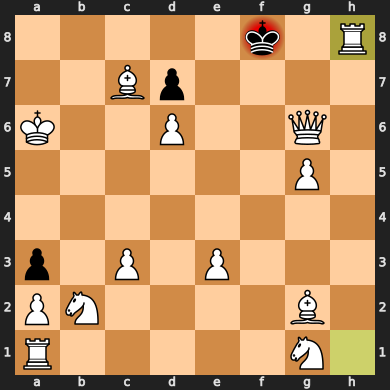

In [10]:
learner.learn(iters=n_iters,timelimit_seconds=timelimit,c=network_replacement_interval, maxiter=2*n_iters)

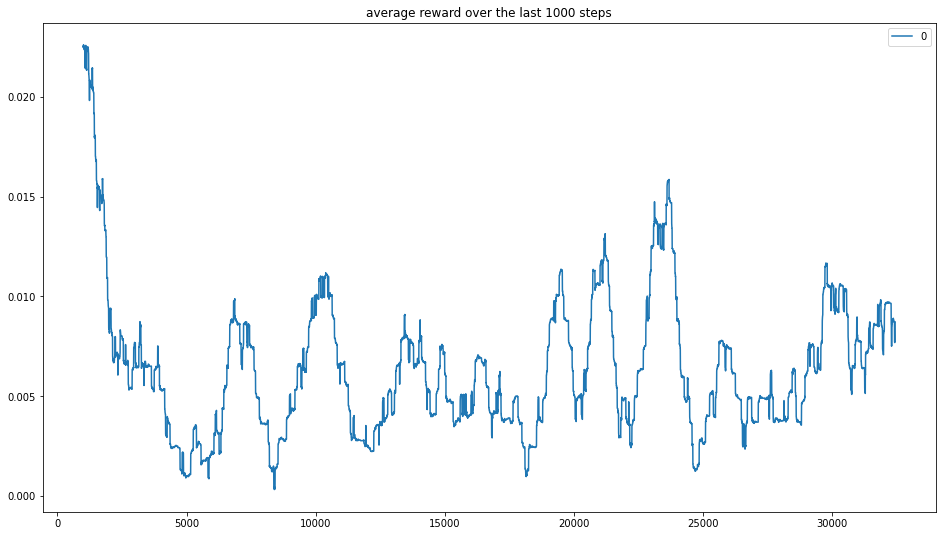

In [11]:
import pandas as pd

reward_smooth = pd.DataFrame(learner.reward_trace)
reward_smooth.rolling(window=1000,min_periods=1000).mean().plot(figsize=(16,9),title='average reward over the last 1000 steps')
plt.show()

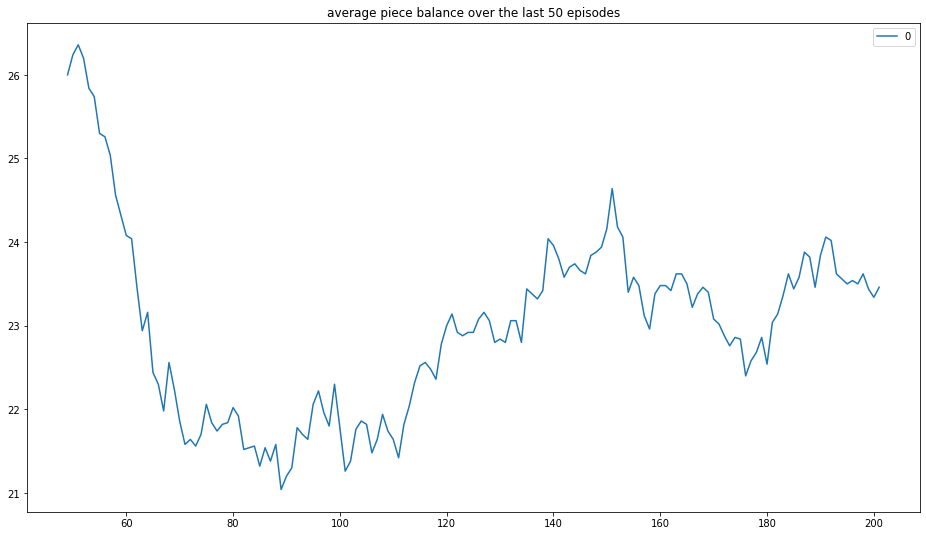

In [12]:
reward_smooth = pd.DataFrame(learner.piece_balance_trace)
reward_smooth.rolling(window=50,min_periods=50).mean().plot(figsize=(16,9),title='average piece balance over the last 50 episodes')
plt.show()

In [13]:
learner.env.reset()
learner.search_time = 60
learner.temperature = 1/3

8/6k1/3p4/6B1/4N3/2K3PR/P3N1B1/8 b - - 8 65
game ended with result 0.0 and material balance 18.0 in 129 halfmoves


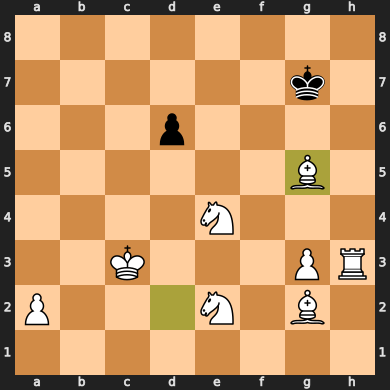

In [14]:
learner.play_game(n_iters,maxiter=128)

In [15]:
learner.agent.model.save('RLC_model_v4_6_stockfish.h5')